# Note!

To run this notebook, you first need to train models using the bash script we provide (toy_script.sh). 

Then in the cell number 5 enter the Path to a valid model.

In [1]:
import sys
sys.path.insert(0, '../')

from tqdm.auto import tqdm
import torch
from src.config.models import NatPnModelVanilla
from data.utils.datasets import DATASETS
from data.utils.constants import MEAN, STD
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import Compose, Normalize
from src.config.utils import evaluate
from src.config.nat_pn.loss import BayesianLoss
from typing import Optional

from src.config.visualization import plot_density_slice_2d

import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
import matplotlib
def pretty_matplotlib_config(fontsize=15):
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rcParams['text.usetex'] = True
    matplotlib.rcParams.update({'font.size': fontsize})
    
pretty_matplotlib_config(40)

In [3]:
import os
from collections import defaultdict
import pickle

In [4]:
dataset_name = 'toy_noisy'

In [5]:
with open(f'../data/{dataset_name}/partition.pkl', 'rb') as file:
    partition = pickle.load(file, )
data_indices: list[list[int]] = partition["data_indices"]

transform = Compose(
    [Normalize(MEAN[dataset_name], STD[dataset_name])]
)

In [6]:
# base_path = YOUR PATH HERE
# for example base_path = "../out/FedAvg/"


classes2modelpath = defaultdict(list)
for file in os.listdir(base_path):
    if file.endswith('toy_noisy_1_natpn.pt') and file.find('stopgrad') == -1:
        n_classes = int(file.split('_')[2])
        classes2modelpath[n_classes].append(os.path.join(base_path, file))

In [7]:
def create_model(n_classes):
    model = NatPnModelVanilla(dataset="toy_noisy" + f"_{n_classes}",
                       backbone='2nn',
                       stop_grad_logp=False,
                       stop_grad_embeddings=False
                      )
    return model

In [8]:
n_classes = 150
model = create_model(n_classes)

models = []
for modelpath in classes2modelpath[n_classes]:
    all_params_dict = torch.load(modelpath)
    model = create_model(n_classes)
    model.load_state_dict(all_params_dict["global"], strict=False)
    model.eval()
    
    models.append(model)

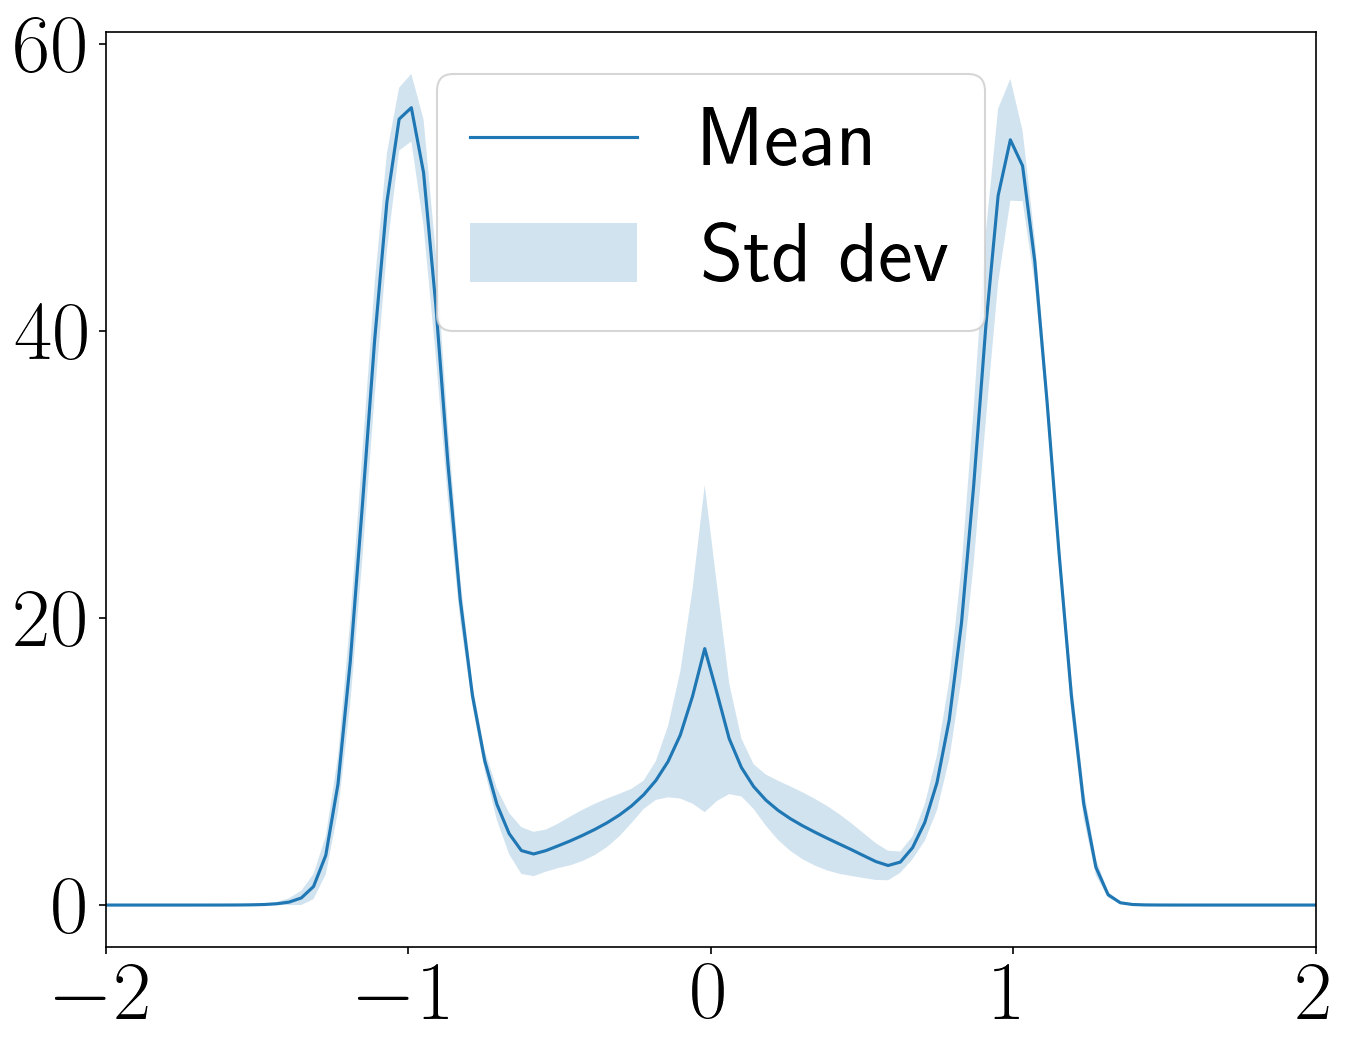

In [10]:
plot_density_slice_2d(slice_coord=0.,
                      y_fixed=True,
                      limits=[-2., 2.],
                      n_steps=100,
                      models=models,
                      device="cpu", )

In [11]:
sorted(classes2modelpath.keys())

[3, 5, 10, 15, 20, 30, 40, 50, 75, 100, 150, 200]

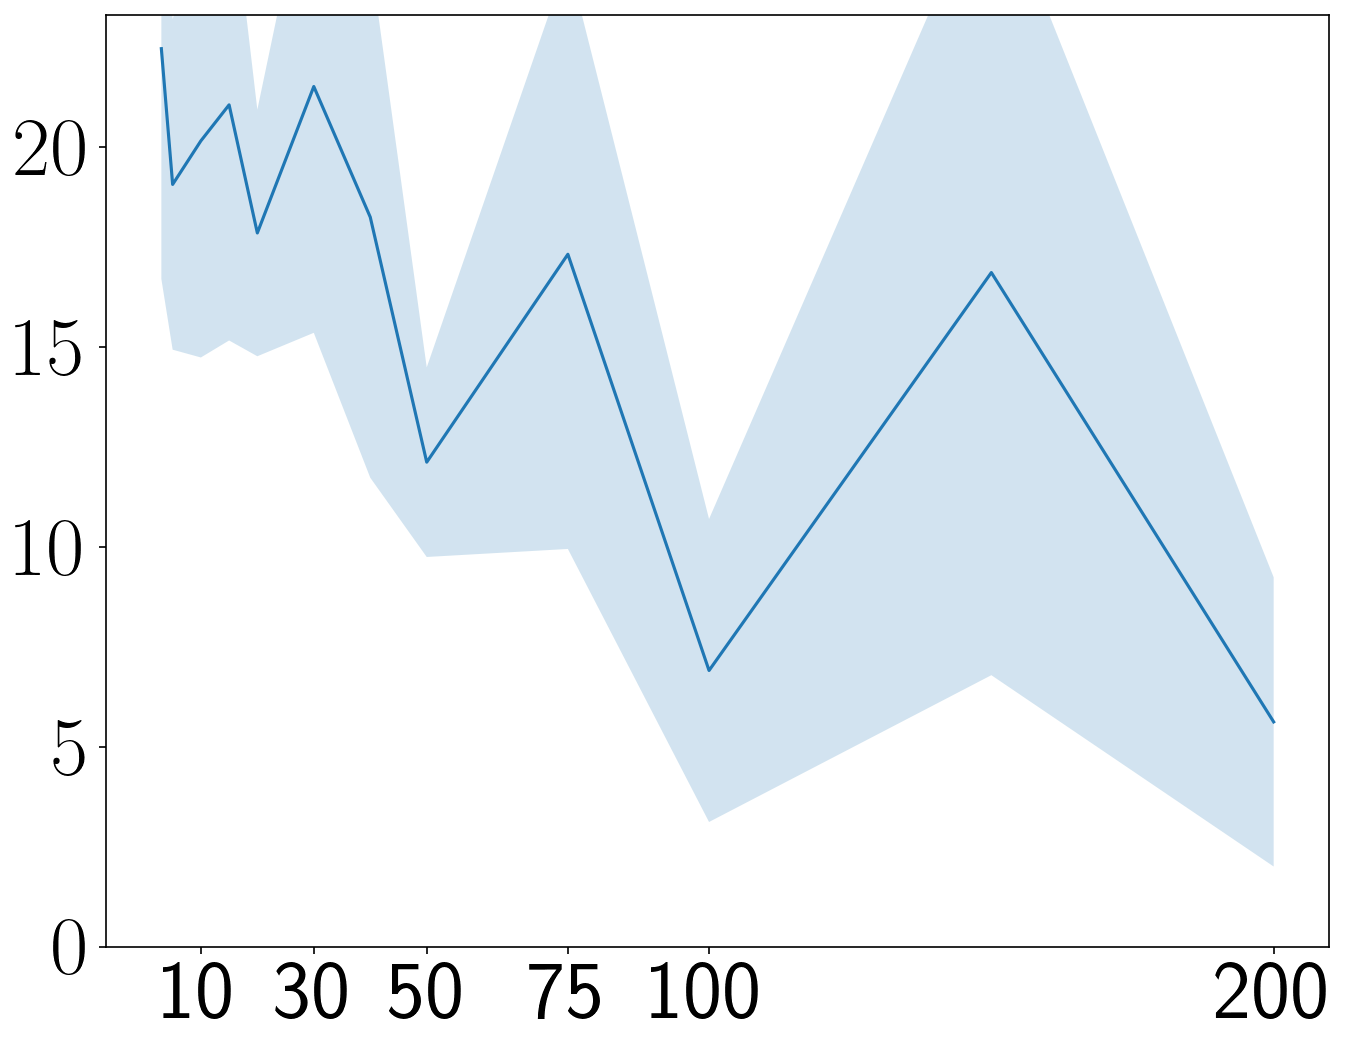

In [12]:
all_prob_values = []
selected_n_classes = []
for n_classes in sorted(classes2modelpath.keys()):
    selected_n_classes.append(n_classes)
    points = torch.tensor([[0., 0.]], dtype=torch.float32)
    
    prob_values = []
    with torch.no_grad():
        for path in classes2modelpath[n_classes]:
            model = create_model(n_classes)

            all_params_dict = torch.load(path)
            model.load_state_dict(all_params_dict["global"], strict=False)
            model.eval()

            _, log_probs, _ = model.train_forward(points)

            prob_values.append(log_probs.cpu().numpy())
            
    all_prob_values.append(np.hstack(prob_values))
all_prob_values = np.vstack(all_prob_values)

plt.figure(dpi=150, figsize=(10, 8))

mean = np.exp(all_prob_values).mean(1)
std = np.exp(all_prob_values).std(1)

plt.plot(selected_n_classes, mean, )

x_tick_positions = [10, 30, 50, 75, 100, 200]  # Tick positions from 0 to 10 with a step of 1
x_tick_labels = x_tick_positions  # Format tick labels
plt.xticks(x_tick_positions, x_tick_labels)
plt.ylim(bottom=0)
plt.fill_between(selected_n_classes, mean - std, mean + std, alpha=0.2)
plt.tight_layout()
# plt.savefig('mid_mode_density_degradating.pdf', format='pdf')
plt.show()